In [48]:
from sklearn.metrics import accuracy_score, f1_score, precision_score,make_scorer, recall_score , confusion_matrix
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.model_selection import KFold, cross_val_score 
import numpy as np
from sklearn.model_selection import GridSearchCV , cross_val_score 
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import  StandardScaler, OneHotEncoder
from hyperopt import fmin , tpe , hp
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
import warnings
warnings.filterwarnings("ignore")

In [64]:
df = pd.read_excel('CHURNDATA (1) (1).xlsx')
df.head(2)

,CIF,CUS_DOB,AGE,CUS_Month_Income,CUS_Gender,CUS_Marital_Status,CUS_Customer_Since,YEARS_WITH_US,# total debit transactions for S1,# total debit transactions for S2,...,total credit amount for S2,total credit amount for S3,total debit amount,total debit transactions,total credit amount,total credit transactions,total transactions,CUS_Target,TAR_Desc,Status
0,XXXXXX,Feb 13 1970 12:00AM,49,7116.64,MALE,MARRIED,1994-06-30,25,277,265,...,1764079.61,2378592.62,4758311.63,887,5659653.33,65,952,2231,EXECUTIVE,ACTIVE
1,XXXXXX,Sep 20 1973 12:00AM,46,1500000.00,FEMALE,SINGLE,2005-05-19,14,37,15,...,19500.00,57500.00,139363.22,97,87000.00,10,107,2223,LOW,ACTIVE


In [65]:
df.columns

Index(['CIF', 'CUS_DOB', 'AGE', 'CUS_Month_Income', 'CUS_Gender',
       'CUS_Marital_Status', 'CUS_Customer_Since', 'YEARS_WITH_US',
       '# total debit transactions for S1',
       '# total debit transactions for S2',
       '# total debit transactions for S3', 'total debit amount for S1',
       'total debit amount for S2', 'total debit amount for S3',
       '# total credit transactions for S1',
       '# total credit transactions for S2',
       '# total credit transactions for S3', 'total credit amount for S1',
       'total credit amount for S2', 'total credit amount for S3',
       'total debit amount', 'total debit transactions', 'total credit amount',
       'total credit transactions', 'total transactions', 'CUS_Target',
       'TAR_Desc', 'Status'],
      dtype='object')

In [50]:
# delete cols

del df['CIF']
del df['CUS_DOB']
del df['CUS_Customer_Since']
del df['total debit transactions']
del df['total credit transactions']
del df['total transactions']
del df['TAR_Desc']
del df['CUS_Target']


In [51]:
df.dropna(inplace = True)

In [52]:
# Encoding Target Column
df['Status'] = df['Status'].map({'ACTIVE':0 , 'CHURN':1})

In [53]:
X = df.drop(columns=['Status'] , axis=1)
y = df['Status']

# Column Transformer

In [54]:
columns_to_encode = ['CUS_Gender','CUS_Marital_Status']
scaling = ['AGE','CUS_Month_Income','YEARS_WITH_US', '# total debit transactions for S1',
       '# total debit transactions for S2',
       '# total debit transactions for S3', 'total debit amount for S1',
       'total debit amount for S2', 'total debit amount for S3',
       '# total credit transactions for S1',
       '# total credit transactions for S2',
       '# total credit transactions for S3', 'total credit amount for S1',
       'total credit amount for S2', 'total credit amount for S3',
       ]


In [55]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), columns_to_encode)
    ],
    remainder='passthrough'
)

# Apply the preprocessing to your DataFrame
X_preprocessed = preprocessor.fit_transform(X)

# Convert the transformed data back to a DataFrame
X_preprocessed_df = pd.DataFrame(X_preprocessed)
# Now, X_preprocessed_df contains the preprocessed data
X_preprocessed_df.head(1)

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,49.0,7116.64,...,1230543.08,2068641.91,10.0,24.0,31.0,1516981.1,1764079.61,2378592.62,4758311.63,5659653.33


#### Smote Oversampling

In [56]:
smote = SMOTE()
X_resampled , y_resampled = smote.fit_resample(X_preprocessed_df , y)

### Training model

In [57]:
def train_and_evaluate(model, X, y, test_size=0.2, random_state=42):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Calculate metrics
    train_accuracy = model.score(X_train, y_train)
    test_accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    # Output the metrics
    metrics = {
        'Train Accuracy': train_accuracy,
        'Test Accuracy': test_accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'confusion mat' : confusion_matrix(y_test ,y_pred)
    }
    return metrics

### using GridSearchCV

In [58]:
extra_tree = ExtraTreesClassifier()

# Define the hyperparameter grid to search
param_grid = {
    'n_estimators': [50, 100, 200],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create the grid search object
grid_search = GridSearchCV(extra_tree, param_grid, cv=5, scoring='precision')

# Fit the grid search to the data
grid_search.fit(X_resampled, y_resampled)
grid_search.best_params_


{'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}

### Trying Hyperopt

In [59]:
def objective(params):
    model = ExtraTreesClassifier(
        n_estimators=params['n_estimators'],
        max_depth=params['max_depth'],
        min_samples_split=params['min_samples_split'],
        min_samples_leaf=params['min_samples_leaf'],
        max_features=params['max_features'],
        random_state=42
    )
    score = cross_val_score(model, X_resampled, y_resampled).mean()
    return -score  # Minimize, so negative of the score

space = {
    'n_estimators': hp.choice('n_estimators', range(50, 200)),
    'max_depth': hp.choice('max_depth', range(1, 100)),
    'min_samples_split': hp.uniform('min_samples_split', 0.1, 1.0),
    'min_samples_leaf': hp.uniform('min_samples_leaf', 0.1, 0.5),
    'max_features': hp.choice('max_features', ['auto', 'sqrt', 'log2', None])
}

# You can adjust the max_evals based on your computational resources
best_params = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=100)

print("Best parameters:", best_params)

100%|█████████████████████████████████████████████| 100/100 [01:32<00:00,  1.08trial/s, best loss: -0.8172413793103448]
Best parameters: {'max_depth': 11, 'max_features': 3, 'min_samples_leaf': 0.11081777283053881, 'min_samples_split': 0.4600454482681997, 'n_estimators': 79}


###  CRoss Val score check -- scoring  precision

In [60]:
precision_scorer = make_scorer(precision_score, pos_label=1)  # Set pos_label to the label of the positive class

# Perform cross-validation with precision as the scoring metric
cross_val_precision = cross_val_score(ExtraTreesClassifier(n_estimators=100), X_resampled, y_resampled, cv=5, scoring=precision_scorer)
np.mean(cross_val_precision) , cross_val_precision

(0.903224807928684,
 array([0.9205298 , 0.90232558, 0.93809524, 0.85106383, 0.90410959]))

### Training the model

In [61]:
metrics = train_and_evaluate( ExtraTreesClassifier(), X_resampled, y_resampled)
metrics

{'Train Accuracy': 1.0,
 'Test Accuracy': 0.9261083743842364,
 'Precision': 0.9074889867841409,
 'Recall': 0.958139534883721,
 'F1 Score': 0.9321266968325792,
 'confusion mat': array([[170,  21],
        [  9, 206]], dtype=int64)}

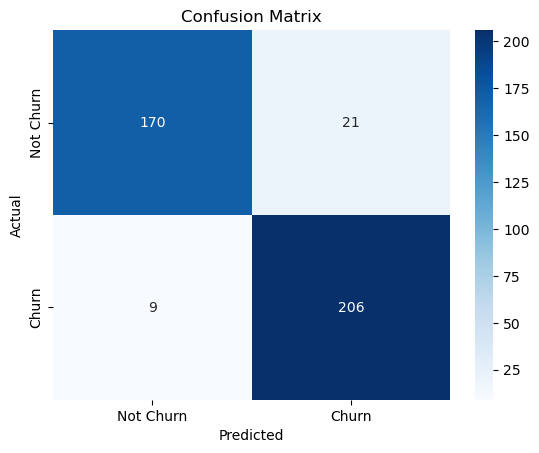

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.heatmap(metrics['confusion mat'], annot=True, fmt='d', cmap='Blues', xticklabels=['Not Churn', 'Churn'], yticklabels=['Not Churn', 'Churn'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()